# Modelling Notebook for Rob's Sleep Schedule

In [83]:
import pandas as pd
import numpy as np
from plotnine import *
from mizani.formatters import comma_format, custom_format, currency_format
import seaborn as sns
import matplotlib.pyplot as plt

from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.impute import SimpleImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer, KNNImputer
from sklearn.pipeline import FeatureUnion, make_pipeline, Pipeline
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.metrics import r2_score, mean_absolute_error, mean_absolute_percentage_error, mean_squared_error
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn import config_context

pd.set_option('display.max.columns', 500)
%matplotlib inline

Mandatory 'bruh' for the amount of imports in Python:

<img src="https://i.ytimg.com/vi/8MOtth7Vln8/hqdefault.jpg" alt="drawing" width="250"/>

In [84]:
# Import data 
train = pd.read_csv("Data/train_prepped_final.csv")
test = pd.read_csv("Data/test_prepped_final.csv")

Try out training only on most recent data:

In [85]:
train = train.query('year >= 2019').reset_index(drop=True)

In [86]:
train.value_counts('year')

year
2019    360
2020    358
2021    356
dtype: int64

As the test doesn't containt the true target, split train further into test and train:

# Important: Can't just do random split here!!! This is time series data, need to keep a time period out!!

In [87]:
X, y = train.drop(['sleep_hours', 'date'], axis=1), train.sleep_hours

In [88]:
X_train, X_test = train.query('year < 2021').drop(['sleep_hours', 'date'], axis=1), train.query('year == 2021').drop(['sleep_hours', 'date'], axis=1)
y_train, y_test = train.query('year < 2021')['sleep_hours'], train.query('year == 2021')['sleep_hours']

In [89]:
X_train.shape

(718, 79)

In [90]:
X_test.shape

(356, 79)

In [91]:
# Convert objects to categories
for dataset in [X_train, X_test]:
    for col in dataset.select_dtypes(include="object").columns:
        dataset[col] = dataset[col].astype("category")

### Modelling LGBM

In [92]:
# Making column selectors for dtypes
num_cols = make_column_selector(dtype_include="number")
cat_cols = make_column_selector(dtype_exclude="number")

# Making pipelines for column transformer
numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy='median')),
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy='most_frequent')),
    ("encoder", OneHotEncoder(max_categories=30,
                              handle_unknown='ignore')),
])

# Making column transformer
preprocessor = ColumnTransformer(
    transformers=[("numeric", numeric_transformer, num_cols),
                  ("categorical", categorical_transformer, cat_cols)],
    remainder="passthrough"
)

# Making model pipeline for lightgbm
lgbm_pipeline = Pipeline(steps=[
    ("preprocessing", preprocessor),
    ("LGBMmodel", LGBMRegressor())
])

In [105]:
# see transformed dataset
pd.DataFrame(lgbm_pipeline[:-1].fit_transform(X_train, y_train),
             columns=lgbm_pipeline[:-1].get_feature_names_out())

,numeric__numeric__active_energy,numeric__numeric__exercise_minutes,numeric__numeric__HKCategoryValueAppleStandHourIdle,numeric__numeric__HKCategoryValueAppleStandHourStood,numeric__numeric__HKCategoryValueEnvironmentalAudioExposureEventMomentaryLimit,numeric__numeric__minutes_stood,numeric__numeric__basal_energy,numeric__numeric__body_mass,numeric__numeric__body_mass_index,numeric__numeric__distance_walking_running,numeric__numeric__env_audio_exposure_min,numeric__numeric__env_audio_exposure_mean,numeric__numeric__env_audio_exposure_median,numeric__numeric__env_audio_exposure_max,numeric__numeric__flights_climbed,numeric__numeric__headphone_audio_exposure_min,numeric__numeric__headphone_audio_exposure_mean,numeric__numeric__headphone_audio_exposure_median,numeric__numeric__headphone_audio_exposure_max,numeric__numeric__heartrate_min,numeric__numeric__heartrate_mean,numeric__numeric__heartrate_median,numeric__numeric__heartrate_max,numeric__numeric__heartrate_var_min,numeric__numeric__heartrate_var_mean,numeric__numeric__heartrate_var_median,numeric__numeric__heartrate_var_max,numeric__numeric__oxygen_saturation_min,numeric__numeric__oxygen_saturation_mean,numeric__numeric__oxygen_saturation_median,numeric__numeric__oxygen_saturation_max,numeric__numeric__resting_heartrate,numeric__numeric__stair_ascent_speed_min,numeric__numeric__stair_ascent_speed_mean,numeric__numeric__stair_ascent_speed_median,numeric__numeric__stair_ascent_speed_max,numeric__numeric__stair_descent_speed_min,numeric__numeric__stair_descent_speed_mean,numeric__numeric__stair_descent_speed_median,numeric__numeric__stair_descent_speed_max,numeric__numeric__step_count,numeric__numeric__vo2_max,numeric__numeric__walking_asymmetry_min,numeric__numeric__walking_asymmetry_mean,numeric__numeric__walking_asymmetry_median,numeric__numeric__walking_asymmetry_max,numeric__numeric__walking_support_min,numeric__numeric__walking_support_mean,numeric__numeric__walking_support_median,numeric__numeric__walking_support_max,numeric__numeric__walking_heartrate_mean,numeric__numeric__walking_speed_min,numeric__numeric__walking_speed_mean,numeric__numeric__walking_speed_median,numeric__numeric__walking_speed_max,numeric__numeric__walking_steplength_min,numeric__numeric__walking_steplength_mean,numeric__numeric__walking_steplength_median,numeric__numeric__walking_steplength_max,numeric__numeric__year,numeric__numeric__month,numeric__numeric__dom,numeric__numeric__doy,numeric__numeric__week,numeric__numeric__dow,numeric__numeric__quarter,numeric__numeric__is_holiday,numeric__numeric__target_lag_1,numeric__numeric__target_lag_2,numeric__numeric__target_lag_3,numeric__numeric__target_lag_4,numeric__numeric__target_lag_5,numeric__numeric__target_lag_6,numeric__numeric__target_lag_7,numeric__categorical__holiday_Christmas Day,numeric__categorical__holiday_Columbus Day,numeric__categorical__holiday_Independence Day,numeric__categorical__holiday_Independence Day (Observed),numeric__categorical__holiday_Labor Day,numeric__categorical__holiday_Martin Luther King Jr. Day,numeric__categorical__holiday_Memorial Day,numeric__categorical__holiday_New Year's Day,numeric__categorical__holiday_No Holiday,numeric__categorical__holiday_Thanksgiving,numeric__categorical__holiday_Veterans Day,numeric__categorical__holiday_Washington's Birthday
0,-0.081310,-0.065699,0.044251,-0.118504,0.0,-0.067621,-0.406775,-0.816805,-0.849504,-0.220358,0.048828,0.045082,0.066161,-0.094560,-0.674939,0.069121,0.070401,0.070955,0.147975,0.012456,-0.115279,-0.125288,0.140134,-0.010226,-0.028205,-0.005342,-0.083828,-0.039128,-0.032491,-0.106188,0.114602,0.010351,-0.125334,-0.075179,-0.101966,0.060106,-0.154397,-0.084745,-0.131623,0.021458,0.093499,0.084730,0.0,-0.144679,-0.060931,-0.203598,0.034655,-0.068063,-0.071802,-0.036653,-0.029244,0.004337,0.083677,0.090936,-0.006710,-0.077042,0.055333,0.045419,-0.000379,-0.997218,-1.591239,-1.665205,-1.717896,-1.694110,-0.996872,-1.341928,5.907622,1.104813,1.153022,-0.859268,0.042

In [310]:
%%capture --no-stderr

# Create the random grid
# Important: Put the Name of the model from the pipeline including two backspaces
# before the parameter names in the dictionary
lgbm_grid = {
    'LGBMmodel__num_leaves': [int(x) for x in 2**np.linspace(start=3, stop=12, num=10)],
    'LGBMmodel__max_depth': [int(x) for x in np.linspace(start=3, stop=12, num=10)],
    'LGBMmodel__min_data_in_leaf': [int(x) for x in 2**np.linspace(start=1, stop=12, num=12)],
    'LGBMmodel__learning_rate' : 10**(-1*np.linspace(start=0.01, stop=5, num=20)),
    'LGBMmodel__n_estimators': [int(x) for x in np.linspace(start=10, stop=1000, num=12)]
}

lgbm_search = (RandomizedSearchCV(lgbm_pipeline, param_distributions=lgbm_grid, n_iter=500,
                                  verbose=1, cv=3, scoring="neg_root_mean_squared_error")
               .fit(X_train, y_train))

Fitting 3 folds for each of 500 candidates, totalling 1500 fits
[LightGBM] [Warning] min_data_in_leaf is set=2048, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2048
[LightGBM] [Warning] min_data_in_leaf is set=2048, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2048
[LightGBM] [Warning] min_data_in_leaf is set=1024, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1024
[LightGBM] [Warning] min_data_in_leaf is set=1024, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1024
[LightGBM] [Warning] min_data_in_leaf is set=1024, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1024
[LightGBM] [Warning] min_data_in_leaf is set=64, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=64
[LightGBM] [Warning] min_data_in_leaf is set=64, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=64
[LightGBM] [Warning] min_data_in_leaf is set=64, min_child_sam

In [311]:
# Select the hyperparams and the score from the results
lgbm_search_results = (pd.DataFrame(lgbm_search.cv_results_)
                       .filter(["param_" + x for x in list(lgbm_grid.keys())] + ["mean_test_score"]))

# Clean up column headers
lgbm_search_results.columns = lgbm_search_results.columns.str.replace("param_LGBMmodel__", "")

# lgbm_search_results.sort_values("mean_test_score", ascending=False)
lgbm_search_results.describe()


,mean_test_score
count,500.000000
mean,-0.998160
std,0.074328
min,-1.423899
25%,-0.971819
50%,-0.971819
75%,-0.971396
max,-0.963887


In [312]:
pd.DataFrame(lgbm_search.cv_results_).head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_LGBMmodel__num_leaves,param_LGBMmodel__n_estimators,param_LGBMmodel__min_data_in_leaf,param_LGBMmodel__max_depth,param_LGBMmodel__learning_rate,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,0.036486,0.008318,0.012786,0.003853,1024,910,2048,10,0.000112,"{'LGBMmodel__num_leaves': 1024, 'LGBMmodel__n_...",-0.847454,-1.038832,-1.029172,-0.971819,0.088028,165
1,0.027215,0.001289,0.008667,0.000943,1024,280,1024,3,0.533788,"{'LGBMmodel__num_leaves': 1024, 'LGBMmodel__n_...",-0.847454,-1.038832,-1.029172,-0.971819,0.088028,165
2,0.110098,0.004834,0.009334,0.000472,32,730,64,3,0.000206,"{'LGBMmodel__num_leaves': 32, 'LGBMmodel__n_es...",-0.846335,-1.035439,-1.026826,-0.969533,0.087185,72
3,0.036560,0.000623,0.010340,0.002634,32,730,512,5,0.000206,"{'LGBMmodel__num_leaves': 32, 'LGBMmodel__n_es...",-0.847454,-1.038832,-1.029172,-0.971819,0.088028,165
4,0.080995,0.033359,0.010001,0.000817,8,100,4,9,0.000112,"{'LGBMmodel__num_leaves': 8, 'LGBMmodel__n_est...",-0.846242,-1.038663,-1.028878,-0.971261,0.088492,122


In [313]:
# Print the metrics for LGBM
print("LGBM Final Fit Metrics:")
print("--------------------------------")
print(f"R-Squared: {r2_score(y_pred=lgbm_search.predict(X_test), y_true=y_test)}")
print(f"MAE: {mean_absolute_error(y_pred=lgbm_search.predict(X_test), y_true=y_test)}")
print(f"MAPE: {mean_absolute_percentage_error(y_pred=lgbm_search.predict(X_test), y_true=y_test)}")
print(f"RMSE: {mean_squared_error(y_pred=lgbm_search.predict(X_test), y_true=y_test, squared=False)}")


LGBM Final Fit Metrics:
--------------------------------
R-Squared: -0.1479219577108688
MAE: 0.7002391733606842
MAPE: 0.0995598958453206
RMSE: 0.8957298128189966


In [314]:
pd.DataFrame({"predictions": lgbm_search.predict(X_test),
                   "truth": y_test,
                   "model": "LGBM"})

,predictions,truth,model
718,6.456129,6.333333,LGBM
719,6.402263,5.925000,LGBM
720,6.410549,5.858333,LGBM
721,6.494656,5.883333,LGBM
722,6.551356,6.141667,LGBM
...,...,...,...
1069,6.620627,7.933333,LGBM
1070,6.685435,3.850000,LGBM
1071,6.423320,6.175000,LGBM
1072,6.511573,5.158333,LGBM


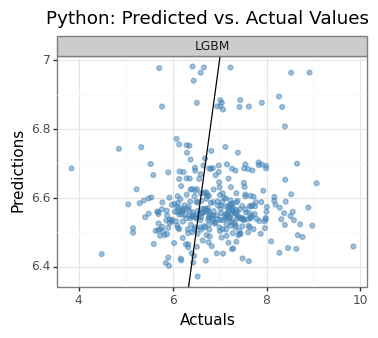

<ggplot: (140616523281)>

In [319]:
p = (
    ggplot(data=(pd.DataFrame({"predictions": lgbm_search.predict(X_test),
                               "truth": y_test,
                               "model": "LGBM"})),
           mapping=aes(x="truth", y="predictions")) +
    geom_point(colour="#4584b6", alpha=0.5) +
    geom_abline() +
    labs(title="Python: Predicted vs. Actual Values",
         y="Predictions", x="Actuals") +
    facet_wrap("~ model") +
    theme_bw() +
    theme(figure_size=[4, 3])
)

p


In [320]:
lgbm_search.best_estimator_

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('numeric',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x0000020BD65CEF80>),
                                                 ('categorical',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 max_categories=30))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x0000020BD65CE380>)])),
                ('LGBMmodel',
                 LGBMRegressor(learning_rate=0.0006893202750501534, max_depth=5,
                               min_data_in_leaf=8, n_estimators=640,
                               num_leaves=16))])

In [323]:
feature_importance = (pd.DataFrame({'importance': lgbm_search.best_estimator_._final_estimator.feature_importances_,
              'feature': lgbm_pipeline[:-1].get_feature_names_out()})
 .sort_values('importance', ascending=False)
 .reset_index(drop=True) 
 )

[Text(0.5, 1.0, 'Feature Importance for LGBM')]

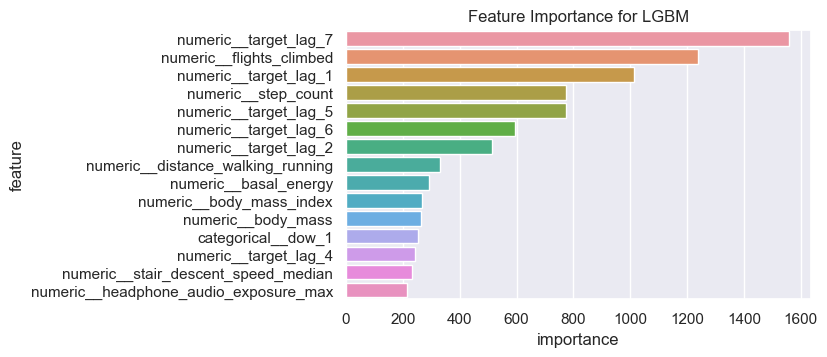

In [324]:
sns.set(rc={'figure.figsize':(6,3.5)})

(sns
 .barplot(data=feature_importance.head(15), x='importance', y='feature')
 .set(title="Feature Importance for LGBM")
 )

Refitting is not necessary (see refit=True in documentation)!

In [210]:
holdout = test.drop(['sleep_hours', 'date'], axis=1)

submission = pd.DataFrame({'date': pd.to_datetime(test.date),
                           'sleep_hours': lgbm_search.predict(holdout)})

submission

,date,sleep_hours
0,2022-01-01,6.639797
1,2022-01-02,6.733616
2,2022-01-03,6.396400
3,2022-01-04,6.396400
4,2022-01-05,6.666726
...,...,...
414,2023-03-12,6.582654
415,2023-03-13,6.397206
416,2023-03-14,6.586756
417,2023-03-15,6.494548


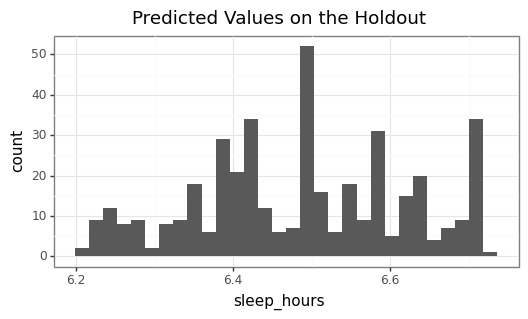

<ggplot: (140612384627)>

In [214]:
(
    ggplot(data=submission,
           mapping=aes(x='sleep_hours')) +
    geom_histogram(bins=30) +
    labs(title='Predicted Values on the Holdout') +
    theme_bw() +
    theme(figure_size=[6,3])
)

In [211]:
submission.to_csv("Predictions/lgbm.csv", index=False)

### Modelling with a Neural Network

In [97]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torch.optim as optim

from IPython.display import clear_output

torch.set_printoptions(edgeitems=2)
torch.manual_seed(123)

In [98]:
# transform datasets with sklearn pipeline for NN
X_train = pd.DataFrame(lgbm_pipeline[:-1].fit_transform(X_train, y_train),
                       columns=lgbm_pipeline[:-1].get_feature_names_out())

X_test = pd.DataFrame(lgbm_pipeline[:-1].fit_transform(X_test, y_test),
                       columns=lgbm_pipeline[:-1].get_feature_names_out())

In [99]:
X_train.shape

(718, 86)

In [106]:
X_train.columns

Index(['numeric__active_energy', 'numeric__exercise_minutes',
       'numeric__HKCategoryValueAppleStandHourIdle',
       'numeric__HKCategoryValueAppleStandHourStood',
       'numeric__HKCategoryValueEnvironmentalAudioExposureEventMomentaryLimit',
       'numeric__minutes_stood', 'numeric__basal_energy', 'numeric__body_mass',
       'numeric__body_mass_index', 'numeric__distance_walking_running',
       'numeric__env_audio_exposure_min', 'numeric__env_audio_exposure_mean',
       'numeric__env_audio_exposure_median', 'numeric__env_audio_exposure_max',
       'numeric__flights_climbed', 'numeric__headphone_audio_exposure_min',
       'numeric__headphone_audio_exposure_mean',
       'numeric__headphone_audio_exposure_median',
       'numeric__headphone_audio_exposure_max', 'numeric__heartrate_min',
       'numeric__heartrate_mean', 'numeric__heartrate_median',
       'numeric__heartrate_max', 'numeric__heartrate_var_min',
       'numeric__heartrate_var_mean', 'numeric__heartrate_var_med

In [113]:
test_columns = X_test.columns.tolist()
train_columns = X_train.columns.tolist()

In [114]:
for column in test_columns:
    if column not in train_columns:
        print(column)

numeric__respiratory_rate_min
numeric__respiratory_rate_mean
numeric__respiratory_rate_median
numeric__respiratory_rate_max
categorical__holiday_Christmas Day (Observed)
categorical__holiday_Juneteenth National Independence Day
categorical__holiday_Juneteenth National Independence Day (Observed)
categorical__holiday_New Year's Day (Observed)


In [115]:
for column in train_columns:
    if column not in test_columns:
        print(column)

numeric__body_mass_index


## Not proceeding with NN

These columns are not in the training dataset (and vice-versa), because the One Hot Encoding in the sklearn pipeline is made separately on train and test. As there is no data at all in respiratory rate before 2019 and holidays vary from year to year, these columns can't exist. This is slightly problematic for a neural network... Don't want to fix this now, more important things to do.

In [100]:
X_test.shape

(356, 93)

In [95]:
class CustomDataset(torch.utils.data.Dataset):
  '''
  Prepare the custom dataset for regression
  '''

  def __init__(self, X, y):
    # Normally, here would be the sklearn part, which I've done above

    if not torch.is_tensor(X) and not torch.is_tensor(y):
      self.X = torch.from_numpy(np.float32(np.asarray(X)))
      self.y = torch.from_numpy(np.float32(np.asarray(y)))

  def __len__(self):
      return len(self.X)

  def __getitem__(self, i):
      return self.X[i], self.y[i]

In [96]:
train_dataset = CustomDataset(X=X_train, y=y_train)
test_dataset = CustomDataset(X=X_test, y=y_test)

train_loader = DataLoader(train_dataset, batch_size=10, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=10, shuffle=False)

ValueError: could not convert string to float: "New Year's Day"

In [56]:
len(X_train.columns)

86

In [42]:
class ANN(nn.Module):
    '''
    Artificial Neural Network
    '''
    def __init__(self):
        super().__init__()
        
        self.layers = nn.Sequential(
            nn.Linear(len(X_train.columns), 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, 1)
        )

    def forward(self, x):
        '''
        Forward pass
        '''
        return self.layers(x)

model = ANN()
model

ANN(
  (layers): Sequential(
    (0): Linear(in_features=86, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=1, bias=True)
  )
)

In [43]:
# Define the loss function and optimizer
loss_function = nn.L1Loss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [44]:
def train_loop(dataloader, model, loss_fn, optimizer, loss_list):
    for X, y in dataloader:
        # Compute prediction and loss
        pred = model(X).squeeze()
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    # Store batch's loss at end of epoch I guess?
    print(f"Training loss: {loss.item():>7f}")
    loss_list.append(loss.item())

def test_loop(dataloader, model, loss_fn, loss_list):
    num_batches = len(dataloader)
    test_loss = 0
    
    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X).squeeze()
            test_loss += loss_fn(pred, y).item()

    test_loss /= num_batches
    print(f"Testing loss: {test_loss:>8f} \n")

    # Store batch's loss at end of epoch I guess?
    loss_list.append(test_loss)

In [63]:
for i, (X,y) in enumerate(train_loader):
    break

In [70]:
X.size()

torch.Size([10, 86])

In [71]:
# Actually running the loops
training_losses = []
testing_losses = []

for t in range(1):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_loader, model, loss_function, optimizer, training_losses)
    # clear output such that the last testing loss remains visible
    clear_output(wait=True)
    test_loop(test_loader, model, loss_function, testing_losses)

RuntimeError: mat1 and mat2 shapes cannot be multiplied (10x93 and 86x128)